# CAE

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tf.enable_eager_execution()

AUTOTUNE = tf.data.experimental.AUTOTUNE

## Load index csv

In [2]:
# TODO update dataset
dataset_index = pd.read_csv('./dataset/tiles-data/data.csv')
print(dataset_index.shape)
print(dataset_index.head())

dataset_size = dataset_index.shape[0]

# append path prefix
dataset_index['image-path'] = './dataset/tiles-resized/' + dataset_index['image-name']
print(dataset_index.shape)
print(dataset_index.head())

# shuffle
dataset_index = dataset_index.reindex(np.random.permutation(dataset_index.index))
print(dataset_index.shape)
print(dataset_index.head())

(629, 3)
  image-name  label    label-name
0      1.jpg     38  bonus-winter
1      2.jpg     26  characters-8
2      3.jpg      9        dots-9
3      4.jpg     36  bonus-summer
4      5.jpg     28   honors-east
(629, 4)
  image-name  label    label-name                     image-path
0      1.jpg     38  bonus-winter  ./dataset/tiles-resized/1.jpg
1      2.jpg     26  characters-8  ./dataset/tiles-resized/2.jpg
2      3.jpg      9        dots-9  ./dataset/tiles-resized/3.jpg
3      4.jpg     36  bonus-summer  ./dataset/tiles-resized/4.jpg
4      5.jpg     28   honors-east  ./dataset/tiles-resized/5.jpg
(629, 4)
    image-name  label    label-name                       image-path
491    492.jpg     22  characters-4  ./dataset/tiles-resized/492.jpg
117    118.jpg     13      bamboo-4  ./dataset/tiles-resized/118.jpg
208    209.jpg     37  bonus-autumn  ./dataset/tiles-resized/209.jpg
241    242.jpg     13      bamboo-4  ./dataset/tiles-resized/242.jpg
235    236.jpg     23  characters-

## Load and rotate images

Instructions for updating:
Colocations handled automatically by placer.


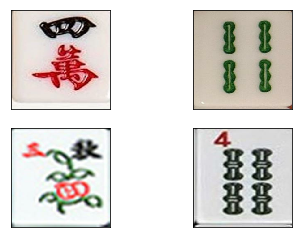

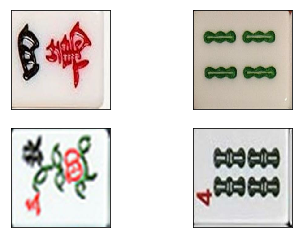

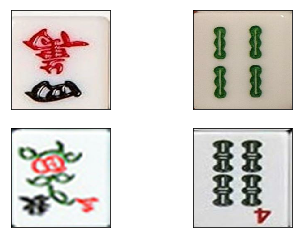

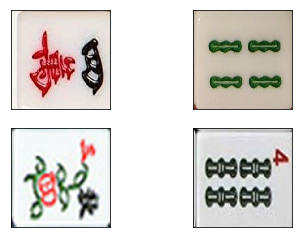

In [3]:
def show_image_sample(ds):
    for n,image in enumerate(ds.take(4)):
        plt.subplot(2,2,n+1)
        plt.imshow(image)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
    plt.show()

def load_and_preprocess_image(path):
    image = tf.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [320, 320])
    image /= 255.0 # normalize to [0,1]
    return image

path_ds = tf.data.Dataset.from_tensor_slices(dataset_index['image-path'])
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
show_image_sample(image_ds)

def rotate_image(image):
    image = tf.image.rot90(image)
    return image

image_ds_90 = image_ds.map(rotate_image, num_parallel_calls=AUTOTUNE)
show_image_sample(image_ds_90)

image_ds_180 = image_ds_90.map(rotate_image, num_parallel_calls=AUTOTUNE)
show_image_sample(image_ds_180)

image_ds_270 = image_ds_180.map(rotate_image, num_parallel_calls=AUTOTUNE)
show_image_sample(image_ds_270)

dataset_size *= 4

## Create image-label pairs

In [4]:
# label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(dataset_index['label'], tf.int64))
# image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
# image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
# image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
# image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

# for n,(image,label) in enumerate(image_label_ds.take(4)):
#     plt.subplot(2,2,n+1)
#     plt.imshow(image)
#     plt.grid(False)
#     plt.xticks([])
#     plt.yticks([])
#     plt.xlabel(label)

## Shuffle, Add noise to input and Split into subsets

(TensorShape([Dimension(320), Dimension(320), Dimension(3)]), TensorShape([Dimension(320), Dimension(320), Dimension(3)]))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


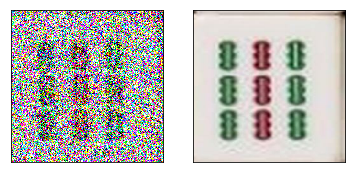

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


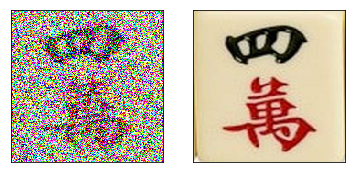

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


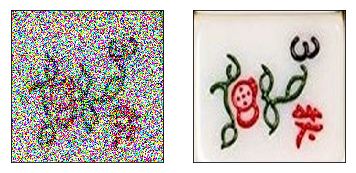

In [4]:
def show_noisy_image_sample(ds):
    ds_iter = ds.make_one_shot_iterator()
    for i in range(3):
        (noisy, orig) = ds_iter.get_next()
        plt.subplot(1,2,1)
        plt.imshow(noisy)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.subplot(1,2,2)
        plt.imshow(orig)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.show()

def add_noise_to_x(x, y):
    x += tf.random.normal(shape=x.shape, mean=0.0, stddev=1.0)
    return x, y

all_image_ds = image_ds.concatenate(image_ds_90).concatenate(image_ds_180).concatenate(image_ds_270)
all_image_ds = tf.data.Dataset.zip((all_image_ds, all_image_ds))
all_image_ds = all_image_ds.shuffle(buffer_size=dataset_size)
all_image_ds = all_image_ds.map(map_func=add_noise_to_x, num_parallel_calls=AUTOTUNE)

# train-test split
train_size = int(dataset_size * 0.7)
val_size = int(dataset_size * 0.15) # test has 0.15 as well

train_ds = all_image_ds.take(train_size)
test_ds = all_image_ds.skip(train_size)
val_ds = test_ds.take(val_size)
test_ds = test_ds.skip(val_size)

print(train_ds.output_shapes)
show_noisy_image_sample(train_ds)

## Train CAE Model

In [5]:
batch_size = 32
# FIXME: use map_and_batch?
# FIXME: cpu bottleneck during data load, prefetch not working?
train_ds_batch = train_ds.batch(batch_size).repeat().prefetch(1)
val_ds_batch = val_ds.batch(batch_size).repeat().prefetch(1)

encoder = keras.Sequential(layers=[
    keras.layers.BatchNormalization(input_shape=(320,320,3)),

    keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),

    keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),

    keras.layers.Conv2D(filters=16, kernel_size=2, strides=1, activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),

    keras.layers.Conv2D(filters=16, kernel_size=2, strides=1, activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),

    keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, activation='relu'),
], name='encoder')

decoder = keras.Sequential(layers=[
    keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=1, activation='relu', input_shape=(16,16,16)),
    keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=1, activation='relu'),
    keras.layers.Conv2DTranspose(filters=16, kernel_size=4, strides=2, activation='relu'),
    keras.layers.Conv2DTranspose(filters=16, kernel_size=4, strides=2, activation='relu'),
    keras.layers.Conv2DTranspose(filters=8, kernel_size=4, strides=2, activation='relu'),
    keras.layers.Conv2DTranspose(filters=8, kernel_size=4, strides=2, activation='relu'),
    keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, activation='sigmoid'),
], name='decoder')

cae = keras.Sequential([encoder, decoder])
cae.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

#     encoder.summary()
#     decoder.summary()
#     cae.summary()

cae.fit(x=train_ds_batch,
        epochs=10,
        steps_per_epoch=int(train_size/batch_size),
        validation_data=val_ds_batch,
        validation_steps=int(val_size/batch_size),
        callbacks=[keras.callbacks.TensorBoard(log_dir='./logs')]
       )

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
Instructions for updating:
Use tf.cast instead.
55/55 [==============================] - 42s 766ms/step - loss: 0.0700 - acc: 0.3741 - val_loss: 0.0928 - val_acc: 0.5175
Epoch 2/10
55/55 [==============================] - 36s 646ms/step - loss: 0.0341 - acc: 0.5541 - val_loss: 0.0557 - val_acc: 0.5347
Epoch 3/10
55/55 [==============================] - 35s 629ms/step - loss: 0.0264 - acc: 0.5489 - val_loss: 0.0309 - val_acc: 0.5562
Epoch 4/10
55/55 [==============================] - 36s 648ms/step - loss: 0.0244 - acc: 0.5565 - val_loss: 0.0248 - val_acc: 0.5720
Epoch 5/10
55/55 [==============================] - 37s 670ms/step - loss: 0.0230 - acc: 0.5661 - val_loss: 0.0260 - val_acc: 0.5636
Epoch 6/10
55/55 [==============================] - 37s 665ms/step - loss: 0.0230 - acc: 0.5713 - val_loss: 0.0227 - val_acc: 0.5808
Epoch 7/10
55/55 [==============================] - 36s 649ms/step - loss: 0.0226 - acc: 0.5785 - val_loss

## Visualize Predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


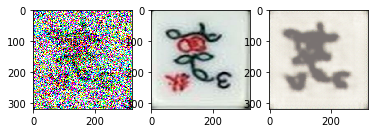

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


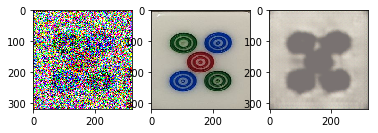

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


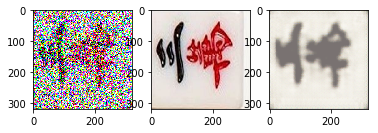

In [6]:
for n, (noisy, orig) in enumerate(val_ds.take(3)):
    plt.subplot(1,3,1)
    plt.imshow(noisy)
    plt.subplot(1,3,2)
    plt.imshow(orig)
    plt.subplot(1,3,3)
    pred = cae.predict_on_batch(x=noisy[np.newaxis,:])[0]
    plt.imshow(pred)
    plt.show()

## Test CAE Model

In [7]:
test_ds_batch = test_ds.batch(batch_size).repeat().prefetch(AUTOTUNE)
cae.evaluate(x=test_ds_batch,
    steps=1
    )

1/1 [==============================] - 15s 15s/step - loss: 0.0220 - acc: 0.6566


[0.021998628973960876, 0.6565637]

## Save models

In [8]:
keras.models.save_model(
    model=encoder,
    filepath='./models/encoder.h5py',
    overwrite=True,
    include_optimizer=True
)

keras.models.save_model(
    model=decoder,
    filepath='./models/decoder.h5py',
    overwrite=True,
    include_optimizer=True
)